In [ ]:
# default_exp core

# Core
> Some basic functions to generate lines, tabbed lines and holes that will be used later when to asemble them into sides of a box

In [1]:
#hide
from nbdev.showdoc import *

In [2]:
#export
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#export
def _get_ax(line):
    """ returns the direction of the line
    [param] line: tuple or np.array of length 4, where 0,1 is point 1 and 3,4 is point 2
    """
    if np.isclose(line[0],line[2]) and line[1] != line[3]:
        return 1
    else:
        return 0

In [4]:
#hide
assert _get_ax([0,0,200,0]) == 0
assert _get_ax([200,0,0,0]) == 0
assert _get_ax([0,200,0,0]) == 1
assert _get_ax([0,0,0,200]) == 1

In [6]:
#export
class OneLine(np.ndarray):
    """
    Class that is baisically an np.array with length of 4 to contain two points.
    It also have some helper functions to move the line in different directions or plot it.
    This class is very simple and are assuming all lines to be orthogonal where the attribute ax tells which direction the line goes.
    ax=0, x-direction (index 0)
    ax=1, y-direction (index 1)
    """
    def __init__(self, a):
        super().__init__()
        self.ax=_get_ax(self)
        self.ay= (self.ax+1)%2
        
    def __new__(cls, line):
        return np.asarray(line, dtype=float).view(cls)
        
    def move_xy(self,x,y):
        "Moves line in x,y direction"
        self +=[x,y,x,y]
        
    def move_in_ax(self, dist):
        "Moves line in the line direction"
        self[[self.ax, self.ax+2]] += dist
        
    def move_in_ay(self, dist):
        "Moves line orthogonal to it's direction"
        ay = (self.ax+1)%2
        self[[ay, ay+2]] += dist
        
    def to_points(self):
        "Converts line to list of points"
        return self.reshape(2,2)
    
    def __repr__(self):
        return f"l: {self}, ax: {self.ax}"
    
    def copy(self):
        return OneLine(self)
    
    def plot(self, **kwargs):
        "Plots current line"
        p = self.to_points()
        plt.plot(p[:,0],p[:,1], **kwargs)
    def __array_finalize__(self, obj):
        if obj is None: return
        self.ax = getattr(obj, 'ax', None)
        self.ay = getattr(obj, 'ay', None)

In [7]:
l = OneLine([0,0,1,0])
assert len(l) == 4
assert l.ax==0
assert l.ay==1

l = OneLine([0,0,0,1])
assert len(l) == 4
assert l.ax==1
assert l.ay==0
assert l.dtype == float
assert l.to_points().shape ==(2,2)

l.ax
l = l[[2,3,0,1]]
l

l: [0. 1. 0. 0.], ax: 1

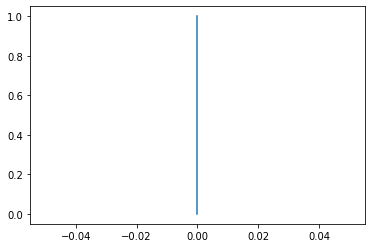

In [8]:
l.plot()

In [9]:
#export
def _line2segmented_pointlist(line, min_tab_mm):
    """
    This fuction splits a line into segments that can be used to generate tabs or holes.
    The min_tab_mm tells the minimum tabsize but might adjusts it a bit larger to always make 
    number of tabs an even number so it's symetrical
    \[param] min_tab_mm
    
    \[return]: list of points, shape (number of segments, 2(x,y))
    """
    line=OneLine(line)
    diff =  line[line.ax+2] - line[line.ax]
    if diff<0:
        line[:] = line[[2,3,0,1]]
    num_tabs = int(abs(diff/min_tab_mm))
    if num_tabs%2==0:
        num_tabs -=1
    tab_size= abs(diff/num_tabs)
    all_tabs = np.arange(line[line.ax], line[line.ax+2]+1, tab_size)
    ret = np.zeros((len(all_tabs),2))
    ret[:,line.ax] = all_tabs
    ret[:,line.ay] = line[line.ay]
    return ret

array([[ 10.        ,   0.        ],
       [ 10.        ,  15.38461538],
       [ 10.        ,  30.76923077],
       [ 10.        ,  46.15384615],
       [ 10.        ,  61.53846154],
       [ 10.        ,  76.92307692],
       [ 10.        ,  92.30769231],
       [ 10.        , 107.69230769],
       [ 10.        , 123.07692308],
       [ 10.        , 138.46153846],
       [ 10.        , 153.84615385],
       [ 10.        , 169.23076923],
       [ 10.        , 184.61538462],
       [ 10.        , 200.        ]])

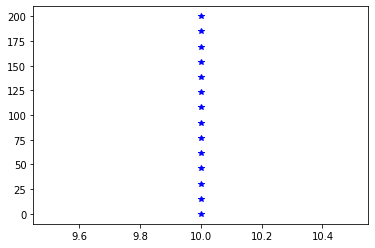

In [10]:
line = [10, 200, 10,0]
segments = _line2segmented_pointlist(line, 15)
assert len(segments)%2==0
plt.plot(segments[:,0], segments[:,1], 'b*')
segments

In [11]:
def plot_lines(lines):
    for l in lines:
        l = l.reshape(2,2)
        plt.plot(l[:,0], l[:,1])

In [12]:
#export
def _segments_to_tabs(segments, ax, thickness):
    """
    genrates tabs from a segmented point list
    You can change if the first tab is male of female by changing the sign of the tab-size
    """
    arr_x = np.repeat(segments[:,ax], 2)
    arr_y = np.tile([0,0, thickness, thickness], len(segments)//2+1)[1:-3]
    ret = np.zeros((len(arr_x),2))
    ret[:,ax] = arr_x
    ay =(ax+1)%2
    ret[:,ay] = arr_y
    points = ret[1:-1,:]
    
    lines = np.hstack([points[:-1], points[1:]])
    #lines = np.hstack
    if thickness <0:
        lines[:,[ay, ay+2]] -= thickness
        
    return lines

In [13]:
l = _line2segmented_pointlist([0,200,0,0], 40)
l

array([[  0.,   0.],
       [  0.,  40.],
       [  0.,  80.],
       [  0., 120.],
       [  0., 160.],
       [  0., 200.]])

In [ ]:
#experiment

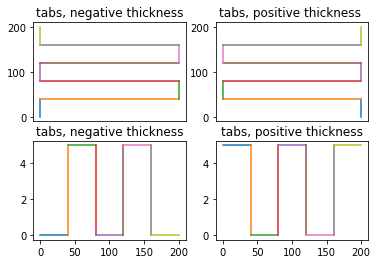

In [93]:
tabsize = 40
thickness = 5
l = 200

line = OneLine([0, l, 0,0])
segments= _line2segmented_pointlist(line, tabsize)
tabs = _segments_to_tabs(segments, line.ax, -thickness)
plt.subplot(2,2,1)
plt.title('tabs, negative thickness')
plot_lines(tabs)
plt.xticks([])
assert np.min(tabs) == 0.0

tabs = _segments_to_tabs(segments, line.ax, thickness)
plt.subplot(2,2,2)
plt.title('tabs, positive thickness ')
plot_lines(tabs)
plt.xticks([])
assert np.min(tabs) == 0.0

line = OneLine([ l,0,  0,0])
segments = _line2segmented_pointlist(line, tabsize)
tabs = _segments_to_tabs(segments, line.ax, -thickness)
plt.subplot(2,2,3)
plt.title('tabs, negative thickness')
plot_lines(tabs)
assert np.min(tabs) == 0.0

tabs = _segments_to_tabs(segments, line.ax, thickness)
plt.subplot(2,2,4)
plt.title('tabs, positive thickness')
plot_lines(tabs)
assert np.min(tabs) == 0.0

In [14]:
#export
def _tabs2holes(tabs, ax):
    tabs=tabs.copy()
    to_modify = np.arange(0,len(tabs)-1,4)
    values_from = np.arange(4,len(tabs),4)
    tabs[to_modify,ax] = tabs[values_from,ax]
    return tabs[:-1]

In [ ]:
# todo how to generate oposite holes? do we need it? - maybe if we want to mess with the inner walls.

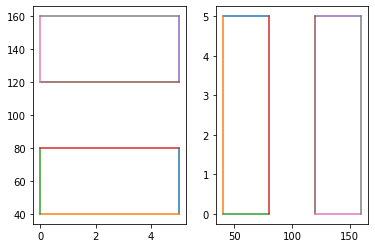

In [31]:
tabsize = 40
thickness = 5
l = 200

line = OneLine([0, l, 0,0])
segments = _line2segmented_pointlist(line, tabsize)
tabs = _segments_to_tabs(segments, line.ax, thickness)
holes = _tabs2holes(tabs, line.ax)
plt.subplot(1,2,1)
plot_lines(holes)

line = OneLine([ l,0,  0,0])
segments = _line2segmented_pointlist(line, tabsize)
tabs = _segments_to_tabs(segments, line.ax, thickness)
holes = _tabs2holes(tabs, line.ax)
plt.subplot(1,2,2)
plot_lines(holes)

In [27]:
class LineObj(np.ndarray):        
    def __new__(cls, lines, ax=None):
        obj = np.asarray(lines, dtype=float).view(LineObj)
        obj.ax = ax
        obj.ay = (ax+1)%2
        obj.mx=0
        obj.my=0
        return obj
        print('new')
        
    @classmethod
    def generate_tabs(cls, line, min_tab_mm, plywood_thick_mm, comp=True):
        line = OneLine(line)
            
        segments = _line2segmented_pointlist(line, min_tab_mm)

        tabs = _segments_to_tabs(segments, line.ax, plywood_thick_mm)
        tabs[:,line.ay] += line[line.ay]
        tabs[:,line.ay+2] += line[line.ay]

        tabs[0,line.ax] += abs(plywood_thick_mm)*comp
        tabs[-1,line.ax+2] -= abs(plywood_thick_mm)*comp
        return cls(tabs, line.ax)
    
    @classmethod
    def generate_holes(cls, line, min_tab_mm, plywood_thick_mm, comp=True):
        """
        
        \[param] comp: True: generates the holes in the middle of the line. otherwize it't on the top of the line
        """
        line = OneLine(line)
            
        segments = _line2segmented_pointlist(line, min_tab_mm)

        tabs = _segments_to_tabs(segments, line.ax, plywood_thick_mm)
        tabs = _tabs2holes(tabs, line.ax)
        # move holes to the position of the line
        tabs[:,line.ay] += line[line.ay] - comp* plywood_thick_mm/2   
        tabs[:,line.ay+2] += line[line.ay] - comp* plywood_thick_mm/2
        return cls(tabs, line.ax)   
        
    def reset_move(self):
        self.mx=0
        self.my=0
        
    def move_xy(self, x, y):
        self += [x,y,x,y]
        self.mx +=x
        self.my +=y
        
    def move_in_ax(self, dist):
        self[:,[self.ax, self.ax+2]] += dist
        if self.ax==0:
            self.mx+=dist
        else:
            self.my+=dist
    def move_in_ay(self, dist):
        ay  = (self.ax+1)%2
        self[:,[ay, ay+2]] += dist
        if self.ax==0:
            self.my+=dist
        else:
            self.mx+=dist
        
    def plot(self):
        for l in self:
            l = l.reshape(2,2)
            plt.plot(l[:,0], l[:,1])
    def __array_finalize__(self, obj):
        if obj is None: return
        self.ax = getattr(obj, 'ax', None)
        self.ay = getattr(obj, 'ay', None)
        self.ax = getattr(obj, 'mx', None)
        self.ay = getattr(obj, 'my', None)

In [ ]:
# testa med negativ thickness.


In [18]:
lines = np.array([[1,2,3,4],[5,6,7,8]])

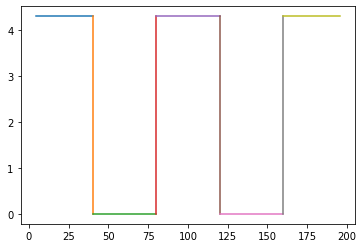

In [21]:
l = LineObj.generate_tabs([200,0,0,0], min_tab_mm=40, plywood_thick_mm=4.3)
l.plot()

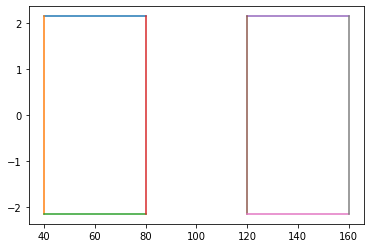

In [30]:
l = LineObj.generate_holes([200,0,0,0], min_tab_mm=40, plywood_thick_mm=4.3)
l.plot()

In [ ]:
# how to do to generate the oposite? of holes?

In [21]:
#hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_generator.ipynb.
Converted index.ipynb.
